In [1]:
import numpy as np
from pyvo.dal.adhoc import DatalinkResults

import lsst.afw.display as afwDisplay
from lsst.afw.image import ExposureF
from lsst.rsp import get_tap_service
from lsst.rsp.utils import get_pyvo_auth

from lsst.rsp import get_tap_service

from pyvo.dal.adhoc import DatalinkResults, SodaQuery
import lsst.geom as geom
from astropy import units as u
from astropy.coordinates import Angle
from astropy.time import Time
import lsst.afw.display as afwDisplay
from lsst.afw.image import ExposureF
from lsst.afw.fits import MemFileManager
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


In [2]:
service = get_tap_service("tap")
assert service is not None

Okay let's pick a SSObject ID sort of at random let's get 4 and we'll use one of them

In [3]:
query = "SELECT * from dp1.SSObject LIMIT 4"


In [4]:


job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()


Job phase is COMPLETED


In [5]:
result = job.fetch_result()
result_df = pd.DataFrame(result)

In [6]:
result_df

,discoverySubmissionDate,numObs,ssObjectId
0,NaN,3,20890932542191434
1,NaN,8,20890945661711695
2,NaN,6,20890950007009348
3,NaN,19,20890950007009349


Let's pick the last one in the table above and get the visit ID for one an observation of it

In [7]:
query = f"SELECT * from dp1.DiaSource where  ssObjectId={result_df.ssObjectId[3]} limit 1"
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

result = job.fetch_result()
result_df = pd.DataFrame(result)   

Job phase is COMPLETED


In [8]:
result_df

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,trailDec,trailFlux,trailLength,trailRa,trail_flag_edge,visit,x,xErr,y,yErr
0,996008.0,1147.569946,False,False,i,47,False,7.498385,38.631196,7.498385,...,7.498385,957175.0,0.533714,38.631196,False,2024112300235,3588.230163,0.003815,1394.236774,0.004072


In [9]:
result_df.visit[0], result_df.trailRa[0], result_df.trailDec[0], result_df.band[0]

(np.int64(2024112300235),
 np.float64(38.631196236878026),
 np.float64(7.498385234005235),
 np.str_('i'))

Now let's setup up some variables we'll use to grab some cutouts

In [10]:
target_ra = result_df.trailRa[0]
target_dec = result_df.trailDec[0]
visitid = result_df.visit[0]
visitband=result_df.band[0]
circle = (target_ra, target_dec, 0.05)

Starting with displaying in matplotlib

In [11]:
afwDisplay.setDefaultBackend('matplotlib')
afw_display = afwDisplay.Display(frame=1)

<Figure size 640x480 with 0 Axes>

Now use ivoa Obscore data to get the specific part of the Rubin image we want to make a cutout of

In [12]:

query = """SELECT * FROM ivoa.ObsCore
        WHERE dataproduct_subtype = 'lsst.visit_image' and lsst_visit={} and CONTAINS(POINT('ICRS', {},{}), s_region) = 1
        """.format(visitid, target_ra, target_dec)
print(query)


SELECT * FROM ivoa.ObsCore
        WHERE dataproduct_subtype = 'lsst.visit_image' and lsst_visit=2024112300235 and CONTAINS(POINT('ICRS', 38.631196236878026,7.498385234005235), s_region) = 1
        


In [13]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'
results = job.fetch_result().to_table()
print(len(results))

Job phase is COMPLETED
1


In [14]:
results

dataproduct_type,dataproduct_subtype,calib_level,lsst_band,em_min,em_max,lsst_tract,lsst_patch,lsst_filter,lsst_visit,lsst_detector,t_exptime,t_min,t_max,s_ra,s_dec,s_fov,obs_id,obs_collection,o_ucd,facility_name,instrument_name,obs_title,s_region,access_url,access_format,obs_publisher_did,target_name,s_resolution,s_xel1,s_xel2,t_resolution,t_xel,pol_xel,em_xel,em_res_power
,,,,m,m,,,,,,s,d,d,deg,deg,deg,,,,,,,,,,,,arcsec,,,s,,,,
object,object,int32,object,float64,float64,int64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,float64,int64,int64,float64,int64,int64,int64,float64
image,lsst.visit_image,2,i,6.936e-07,8.188e-07,--,--,i_06,2024112300235,2,30.0,60638.13755971054,60638.13791194445,38.542475330573815,7.469010313870604,0.31786067602572704,CC_O_20241123_000235,LSST.DP1,phot.flux.density,Rubin:Simonyi,LSSTComCam,visit_image - i - CC_O_20241123_000235-R22_S02 2024-11-24T03:18:05.158991Z,POLYGON ICRS 38.662253 7.574642 38.433845 7.585718 38.422789 7.363366 38.650988 7.352228,https://data.lsst.cloud/api/datalink/links?ID=ivo%3A%2F%2Forg.rubinobs%2Flsst-dp1%3Frepo%3Ddp1%26id%3D909c8d74-939e-4c0b-a155-601734eab09f,application/x-votable+xml;content=datalink,ivo://org.rubinobs/usdac/lsst-dp1?repo=dp1&id=909c8d74-939e-4c0b-a155-601734eab09f,Rubin_SV_38_7,--,4072,4000,--,--,--,--,--


Let's grab the image data and make the cutout

In [15]:
datalink_url = results['access_url'][0]
dl_result = DatalinkResults.from_result_url(datalink_url, session=get_pyvo_auth())
image_url = dl_result.getrecord(0).get('access_url')

In [16]:

sq = SodaQuery.from_resource(dl_result,
                             dl_result.get_adhocservice_by_id("cutout-sync-exposure"),
                             session=get_pyvo_auth())


In [17]:


spherePoint = geom.SpherePoint(target_ra*geom.degrees, target_dec*geom.degrees)
Radius = 0.01 * u.deg
sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             Radius)


In [18]:


cutout_bytes = sq.execute_stream().read()
sq.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)


Display the cutout

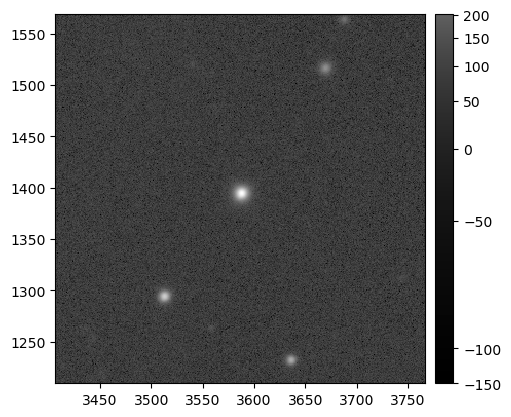

In [19]:


display = afwDisplay.Display()
display.scale('asinh', 'zscale')
display.image(exposure.image)
plt.show()


In [20]:
afw_display.setMaskTransparency(100)

Now display the cutout in the Firefly viewer

In [21]:


afwDisplay.setDefaultBackend("firefly")
display = afwDisplay.Display(frame=1)
display.scale('asinh', 'zscale')
display.image(exposure.image)
plt.show()


Let's do this again but to find another observation where the object is somewhere else so we can show it is moving

In [22]:

query = """SELECT * FROM ivoa.ObsCore
        WHERE dataproduct_subtype = 'lsst.visit_image' and lsst_visit!={} and lsst_band='{}' and CONTAINS(POINT('ICRS', {},{}), s_region) = 1
        """.format(visitid, visitband, target_ra, target_dec)
print(query)

SELECT * FROM ivoa.ObsCore
        WHERE dataproduct_subtype = 'lsst.visit_image' and lsst_visit!=2024112300235 and lsst_band='i' and CONTAINS(POINT('ICRS', 38.631196236878026,7.498385234005235), s_region) = 1
        


We're asking to display this cutout in a second frame in the firefly viewer

In [23]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'
results = job.fetch_result().to_table()
print(len(results))

datalink_url = results['access_url'][0]
dl_result = DatalinkResults.from_result_url(datalink_url, session=get_pyvo_auth())
image_url = dl_result.getrecord(0).get('access_url')

sq = SodaQuery.from_resource(dl_result,
                             dl_result.get_adhocservice_by_id("cutout-sync-exposure"),
                             session=get_pyvo_auth())



spherePoint = geom.SpherePoint(target_ra*geom.degrees, target_dec*geom.degrees)
Radius = 0.01 * u.deg
sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             Radius)


cutout_bytes = sq.execute_stream().read()
sq.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)

display = afwDisplay.Display(frame=2)

display.scale('asinh', 'zscale')
display.image(exposure.image)
plt.show()


Job phase is COMPLETED
3


In [24]:
results

dataproduct_type,dataproduct_subtype,calib_level,lsst_band,em_min,em_max,lsst_tract,lsst_patch,lsst_filter,lsst_visit,lsst_detector,t_exptime,t_min,t_max,s_ra,s_dec,s_fov,obs_id,obs_collection,o_ucd,facility_name,instrument_name,obs_title,s_region,access_url,access_format,obs_publisher_did,target_name,s_resolution,s_xel1,s_xel2,t_resolution,t_xel,pol_xel,em_xel,em_res_power
,,,,m,m,,,,,,s,d,d,deg,deg,deg,,,,,,,,,,,,arcsec,,,s,,,,
object,object,int32,object,float64,float64,int64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,float64,int64,int64,float64,int64,int64,int64,float64
image,lsst.visit_image,2,i,6.936e-07,8.188e-07,--,--,i_06,2024112800191,2,30.0,60643.09873817117,60643.09909037037,38.53114193285914,7.528092047318085,0.3177627739697609,CC_O_20241128_000191,LSST.DP1,phot.flux.density,Rubin:Simonyi,LSSTComCam,visit_image - i - CC_O_20241128_000191-R22_S02 2024-11-29T02:22:10.977989Z,POLYGON ICRS 38.659662 7.623028 38.433130 7.653639 38.402706 7.433146 38.629036 7.402475,https://data.lsst.cloud/api/datalink/links?ID=ivo%3A%2F%2Forg.rubinobs%2Flsst-dp1%3Frepo%3Ddp1%26id%3D1de8c281-cadf-4a99-983d-8e28b94f29d0,application/x-votable+xml;content=datalink,ivo://org.rubinobs/usdac/lsst-dp1?repo=dp1&id=1de8c281-cadf-4a99-983d-8e28b94f29d0,Rubin_SV_38_7,--,4072,4000,--,--,--,--,--
image,lsst.visit_image,2,i,6.936e-07,8.188e-07,--,--,i_06,2024112800183,2,30.0,60643.09431458312,60643.09466692129,38.58907171242687,7.444509842478701,0.3177433985831188,CC_O_20241128_000183,LSST.DP1,phot.flux.density,Rubin:Simonyi,LSSTComCam,visit_image - i - CC_O_20241128_000183-R22_S02 2024-11-29T02:15:48.779981Z,POLYGON ICRS 38.728138 7.523433 38.507015 7.580836 38.450089 7.365551 38.671018 7.308140,https://data.lsst.cloud/api/datalink/links?ID=ivo%3A%2F%2Forg.rubinobs%2Flsst-dp1%3Frepo%3Ddp1%26id%3Dee78dd1e-56e4-4a84-8c54-896d419956ac,application/x-votable+xml;content=datalink,ivo://org.rubinobs/usdac/lsst-dp1?repo=dp1&id=ee78dd1e-56e4-4a84-8c54-896d419956ac,Rubin_SV_38_7,--,4072,4000,--,--,--,--,--
image,lsst.visit_image,2,i,6.936e-07,8.188e-07,--,--,i_06,2024112800187,2,30.0,60643.09649635433,60643.09684864584,38.622319048432516,7.474698140114696,0.31790179235605515,CC_O_20241128_000187,LSST.DP1,phot.flux.density,Rubin:Simonyi,LSSTComCam,visit_image - i - CC_O_20241128_000187-R22_S02 2024-11-29T02:18:57.285014Z,POLYGON ICRS 38.761447 7.553691 38.540219 7.610991 38.483297 7.395718 38.704241 7.338306,https://data.lsst.cloud/api/datalink/links?ID=ivo%3A%2F%2Forg.rubinobs%2Flsst-dp1%3Frepo%3Ddp1%26id%3D0a6ff2a5-adf3-46be-a43b-ab61cf88a828,application/x-votable+xml;content=datalink,ivo://org.rubinobs/usdac/lsst-dp1?repo=dp1&id=0a6ff2a5-adf3-46be-a43b-ab61cf88a828,Rubin_SV_38_7,--,4072,4000,--,--,--,--,--
